
**Contract Understanding Atticus Dataset (CUAD) v1** — Expert-annotated NLP dataset for legal contract review (NeurIPS 2021).

This notebook provides a step-by-step analysis of the CUAD dataset, aligned with the **Legal Domain LLM Fine-Tuning Research** goals:

- **Task 1 (T1): Risk Clause Recognition.** 
    - *Goal:* Identify specific risk clauses (Binary Classification / Span Identification).
    - *Nature:* 32 categories where the answer implies the existence of a risk (mostly Yes/No questions, e.g., *Termination for Convenience*, *Uncapped Liability*, *Audit Rights*).
- **Task 2 (T2): Structured Entity Extraction.**
    - *Goal:* Extract specific contract metadata and output strictly as a valid JSON object.
    - *Nature:* 9 categories requiring extraction of values, names, dates, or durations (e.g., *Agreement Date*, *Parties*, *Renewal Term*, *Warranty Duration*).

*(Note: Task 3 (Jurisdiction Identification) utilizes the LEDGAR dataset and is analyzed separately.)*

**Dataset Summary:** 13,000+ expert annotations across 510 commercial contracts, 41 clause categories, 25 contract types.

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import seaborn as sns
import json
from transformers import AutoTokenizer
from pathlib import Path
import csv
import re

c:\Users\aetho\Desktop\fine_tune_llms_research\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:

print("Loading CUAD dataset...")

try:
    # 1. Load the dataset (ignoring verification errors)
    # This results in a DatasetDict containing only a 'train' key with all 511 examples
    cuad = load_dataset(
        "theatticusproject/cuad", 
        download_mode="force_redownload",
        verification_mode="no_checks"
    )

    # 2. Check if a test split exists; if not, create one manually
    if 'test' not in cuad:
        print("Dataset only contains 'train'. Creating a manual 80/20 Train/Test split...")
        
        # Split the 'train' portion: 20% for test, 80% for train.
        # seed=42 ensures the split is the same every time you run it.
        cuad_split = cuad['train'].train_test_split(test_size=0.2, seed=42)
        
        # Replace the original dataset variable with the split version
        cuad = cuad_split

    print("\nDataset Split Successful:")
    print(cuad) # This will now show both 'train' and 'test'
    
except Exception as e:
    print(f"Error loading dataset: {e}")

# 3. Verify the structure
if 'cuad' in locals():
    print(f"\nTraining examples: {len(cuad['train'])}")
    print(f"Test examples: {len(cuad['test'])}")
    
    # Peek at one item from the test set
    print("\nSample from Test Set:")
    print(cuad['test'][0].keys()) # Printing keys only to keep output clean

Loading CUAD dataset...


Generating train split: 100%|██████████| 511/511 [00:00<00:00, 9570.09 examples/s]

Dataset only contains 'train'. Creating a manual 80/20 Train/Test split...

Dataset Split Successful:
DatasetDict({
    train: Dataset({
        features: ['pdf'],
        num_rows: 408
    })
    test: Dataset({
        features: ['pdf'],
        num_rows: 103
    })
})

Training examples: 408
Test examples: 103

Sample from Test Set:
dict_keys(['pdf'])


In [3]:
cuad['train'][0]

{'pdf': <pdfplumber.pdf.PDF at 0x2158c91fb10>}

### Exploring the PDF Content

The dataset returns a `pdfplumber` PDF object in the `pdf` field. We can use this object to extract text, tables, and metadata directly.

In [4]:
# Access the PDF object from the sample
sample = cuad['train'][0]
pdf_obj = sample['pdf']

print(f"PDF Metadata: {pdf_obj.metadata}")
print(f"Total Pages: {len(pdf_obj.pages)}")

# Extract text from the first page
print("\n--- Page 1 Text (Preview) ---")
first_page_text = pdf_obj.pages[0].extract_text()
print(first_page_text[:1000] + "..." if len(first_page_text) > 1000 else first_page_text)
first_page_tables = pdf_obj.pages[0].extract_tables()
print("\n--- Page 1 Tables (Preview) ---")


PDF Metadata: {'Producer': 'EVO HTML to PDF Converter 7.4'}
Total Pages: 5

--- Page 1 Text (Preview) ---
EXHIBIT 10.2
SITE DEVELOPMENT AND HOSTING AGREEMENT
This SITE DEVELOPMENT AND HOSTING AGREEMENT (the "Agreement")
dated as of August 9, 1999 is made between Hanover Direct, Inc. ("HDI"), a New
Jersey Corporation, located at 1500 Harbor Boulevard, Weehawken, NJ 07087, and
The Deerskin Companies, Inc. (the "Company"), a Nevada corporation, located at
2500 Arrowhead Drive, Carson City, NV 89706. Each of the parties hereto shall be
referred to as a "Party".
In consideration of the mutual promises and covenants set
forth below, HDI and the Company agree as follows:
1. HDI's Responsibilities.
1.1 HDI shall design, develop, implement, operate, maintain
and manage, and enable the Company to establish a presence on the World Wide Web
("Site") to make available to Internet users on demand, men's and women's
apparel and accessories from the Deerskin Catalog ("Deerskin Products"). As used
in t

In [5]:
import json

# Define the path to the local CUAD_v1.json file
json_file_path = 'data/cuad/CUAD_v1.json'

print(f"Loading {json_file_path}...")

try:
    with open(json_file_path, 'r') as f:
        cuad_data = json.load(f)
        
    print("Keys in JSON:", cuad_data.keys())
    
    if 'data' in cuad_data:
        print(f"Total contracts in 'data': {len(cuad_data['data'])}")
        
        # Preview the first contract structure
        first_contract = cuad_data['data'][0]
        print("\n--- Structure of a single contract entry ---")
        print("Keys:", first_contract.keys())
        print("Title:", first_contract.get('title'))
        
        if 'paragraphs' in first_contract and len(first_contract['paragraphs']) > 0:
            first_para = first_contract['paragraphs'][0]
            print("\n--- Paragraph keys ---")
            print(first_para.keys())
            
            print("\n--- Context (first 200 chars) ---")
            print(first_para['context'][:200])
            
            print("\n--- Q/A Examples (first 2) ---")
            for qa in first_para['qas'][:2]:
                print(qa)
                
except FileNotFoundError:
    print("File not found. Check the path.")

Loading data/cuad/CUAD_v1.json...
Keys in JSON: dict_keys(['version', 'data'])
Total contracts in 'data': 510

--- Structure of a single contract entry ---
Keys: dict_keys(['title', 'paragraphs'])
Title: LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT

--- Paragraph keys ---
dict_keys(['qas', 'context'])

--- Context (first 200 chars) ---
EXHIBIT 10.6

                              DISTRIBUTOR AGREEMENT

         THIS  DISTRIBUTOR  AGREEMENT (the  "Agreement")  is made by and between Electric City Corp.,  a Delaware  corporation  ("Com

--- Q/A Examples (first 2) ---
{'answers': [{'text': 'DISTRIBUTOR AGREEMENT', 'answer_start': 44}], 'id': 'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT__Document Name', 'question': 'Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract', 'is_impossible': False}
{'answers': [{'text': 'Distributor', 'answer_start': 244}, {'text': 'Electric City Corp.', 'an

## Step 2: Dataset Structure & Schema

Explore the data schema, field types, and splits.

Extract and analyze the 41 CUAD clause categories from the `question` field. Map to research tasks:
- **T1 (Risk Clause Recognition):** Categories corresponding to "Yes/No" risk clauses.
- **T2 (Entity Extraction):** Categories requiring specific string, date, or numeric extraction.

In [6]:
# Define Task 2 categories (Entity Extraction) based on typical extensive extraction needs
# All others are treated as Task 1 (Risk/Clause Recognition)
task_2_categories = [
    "Agreement Date", "Effective Date", "Expiration Date", "Party", 
    "Renewal Term", "Notice Period To Terminate Renewal", "Governing Law",
    "Jurisdiction", "Warranty Duration" 
]

print("Analyzing Task Distributions...")

category_counts = defaultdict(int)
task_1_count = 0
task_2_count = 0

# Check if we have loaded the data from the previous cell
if 'cuad_data' in locals():
    for contract in cuad_data['data']:
        for paragraph in contract['paragraphs']:
            for qa in paragraph['qas']:
                category = qa['question']
                # Check if it has an answer (positive sample)
                if not qa['is_impossible'] and len(qa['answers']) > 0:
                     category_counts[category] += 1
                     
                     # Simple heuristic classification for the sake of this check
                     is_entity_extraction = False
                     for t2 in task_2_categories:
                         if t2 in category: 
                             is_entity_extraction = True
                             break
                    
                     if is_entity_extraction:
                         task_2_count += 1
                     else:
                         task_1_count += 1

    print(f"\nTotal Answered Annotations: {sum(category_counts.values())}")
    print(f"Task 1 (Risk Clause Recognition) Examples: {task_1_count}")
    print(f"Task 2 (Entity Extraction) Examples: {task_2_count}")
    
    # Sort and display counts
    print("\n--- Top 10 Categories by Count ---")
    sorted_cats = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    for cat, count in sorted_cats[:10]:
        task_type = "T2" if any(t2 in cat for t2 in task_2_categories) else "T1"
        print(f"[{task_type}] {cat}: {count}")

else:
    print("cuad_data not found. Please run the JSON loading cell above.")

Analyzing Task Distributions...

Total Answered Annotations: 6702
Task 1 (Risk Clause Recognition) Examples: 4598
Task 2 (Entity Extraction) Examples: 2104

--- Top 10 Categories by Count ---
[T1] Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract: 510
[T1] Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract: 509
[T2] Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract: 470
[T2] Highlight the parts (if any) of this contract related to "Governing Law" that should be reviewed by a lawyer. Details: Which state/country's law governs the interpretation of the contract?: 437
[T2] Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On 

# Load master_clauses csv file

In [26]:
CUAD_PATH = Path('data/cuad') 
MASTER_CLAUSES_PATH = CUAD_PATH/'master_clauses.csv' 

try:
    # Read the file manually using the CSV module first to handle inconsistencies
    data = []
    with open(MASTER_CLAUSES_PATH, 'r', encoding='utf-8', errors='replace') as f:
        # Use csv.Sniffer to deduce format if possible, or enforce standard strictness
        reader = csv.DictReader(f) 
        for i, row in enumerate(reader):
            data.append(row)

    # Convert the list of dicts to a DataFrame
    df = pd.DataFrame(data)

    print(f"Data Loaded Successfully via CSV module.")
    print(f"Total Contracts: {len(df)}")
    print(df.head(3))

except Exception as e:
    print(f"Error: {e}")

Data Loaded Successfully via CSV module.
Total Contracts: 545
                                            Filename   Document Name  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   """"MA"""")""   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...      ['July 11    
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   ['November 15   

     Document Name-Answer   Parties Parties-Answer Agreement Date  \
0  ['8th day of May 2014'    'May 8       2014']""         5/8/14   
1                2006']""   7/11/06     ['July 11        2006']""   
2                2012']""  11/15/12  ['November 15       2012']""   

                               Agreement Date-Answer  \
0  ['This agreement shall begin upon the date of ...   
1                                            7/11/06   
2                                           11/15/12   

                                      Effective Date  \
0                                                      
1  ['The term of this Agreement (th

In [27]:
df.head(3)

,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;,NaN
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,"""""""""MA"""""""")""""",['8th day of May 2014','May 8,"2014']""""",5/8/14,['This agreement shall begin upon the date of ...,,['This agreement shall begin upon the date of ...,12/31/14,...,No,[],No,[],No,[],No,[],No,NaN
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['July 11,"2006']""""",7/11/06,['July 11,"2006']""""",7/11/06,"['The term of this Agreement (the """"""""Initial ...",unless earlier terminated in accordance with ...,shall terminate on June 30,...,No,[],No,[],No,"[""""""""Notwithstanding any other provision of th...",Rogers may terminate this Agreement,at any time,upon sixty (60) days' prior written notice to...,NaN
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['November 15,"2012']""""",11/15/12,['November 15,"2012']""""",11/15/12,[],,['License Term Perpetual,...,Satellite x Pay: Terrestrial,Cable,Satellite x Direct Satellite IP Distribution ...,'Producer further grants to ConvergTV the rig...,at its sole cost and expense,new and different versions of the Program,create foreign language,subtitled or translated versions of the Progr...,including NTCS,NaN


In [28]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove special characters but keep spaces
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Clean column names
df.columns = [clean_text(col).strip() for col in df.columns]
for col in df.columns:
    print(col)

Filename
Document Name
Document NameAnswer
Parties
PartiesAnswer
Agreement Date
Agreement DateAnswer
Effective Date
Effective DateAnswer
Expiration Date
Expiration DateAnswer
Renewal Term
Renewal TermAnswer
Notice Period To Terminate Renewal
Notice Period To Terminate Renewal Answer
Governing Law
Governing LawAnswer
Most Favored Nation
Most Favored NationAnswer
Competitive Restriction Exception
Competitive Restriction ExceptionAnswer
NonCompete
NonCompeteAnswer
Exclusivity
ExclusivityAnswer
NoSolicit Of Customers
NoSolicit Of CustomersAnswer
NoSolicit Of Employees
NoSolicit Of EmployeesAnswer
NonDisparagement
NonDisparagementAnswer
Termination For Convenience
Termination For ConvenienceAnswer
RofrRofoRofn
RofrRofoRofnAnswer
Change Of Control
Change Of ControlAnswer
AntiAssignment
AntiAssignmentAnswer
RevenueProfit Sharing
RevenueProfit SharingAnswer
Price Restrictions
Price RestrictionsAnswer
Minimum Commitment
Minimum CommitmentAnswer
Volume Restriction
Volume RestrictionAnswer
Ip Own

In [29]:
new_columns = {}
for col in df.columns:
    print(f"Processing column: '{col}'")
    if "Answer" in col:
            # Remove "Answer" from the string and append "_Answer" at the end
            new_columns[col] = f"{col.replace('Answer', '').strip()}_Answer"

df = df.rename(columns=new_columns)

Processing column: 'Filename'
Processing column: 'Document Name'
Processing column: 'Document NameAnswer'
Processing column: 'Parties'
Processing column: 'PartiesAnswer'
Processing column: 'Agreement Date'
Processing column: 'Agreement DateAnswer'
Processing column: 'Effective Date'
Processing column: 'Effective DateAnswer'
Processing column: 'Expiration Date'
Processing column: 'Expiration DateAnswer'
Processing column: 'Renewal Term'
Processing column: 'Renewal TermAnswer'
Processing column: 'Notice Period To Terminate Renewal'
Processing column: 'Notice Period To Terminate Renewal Answer'
Processing column: 'Governing Law'
Processing column: 'Governing LawAnswer'
Processing column: 'Most Favored Nation'
Processing column: 'Most Favored NationAnswer'
Processing column: 'Competitive Restriction Exception'
Processing column: 'Competitive Restriction ExceptionAnswer'
Processing column: 'NonCompete'
Processing column: 'NonCompeteAnswer'
Processing column: 'Exclusivity'
Processing column:

In [30]:
for col in df.columns:
    print(col)

Filename
Document Name
Document Name_Answer
Parties
Parties_Answer
Agreement Date
Agreement Date_Answer
Effective Date
Effective Date_Answer
Expiration Date
Expiration Date_Answer
Renewal Term
Renewal Term_Answer
Notice Period To Terminate Renewal
Notice Period To Terminate Renewal_Answer
Governing Law
Governing Law_Answer
Most Favored Nation
Most Favored Nation_Answer
Competitive Restriction Exception
Competitive Restriction Exception_Answer
NonCompete
NonCompete_Answer
Exclusivity
Exclusivity_Answer
NoSolicit Of Customers
NoSolicit Of Customers_Answer
NoSolicit Of Employees
NoSolicit Of Employees_Answer
NonDisparagement
NonDisparagement_Answer
Termination For Convenience
Termination For Convenience_Answer
RofrRofoRofn
RofrRofoRofn_Answer
Change Of Control
Change Of Control_Answer
AntiAssignment
AntiAssignment_Answer
RevenueProfit Sharing
RevenueProfit Sharing_Answer
Price Restrictions
Price Restrictions_Answer
Minimum Commitment
Minimum Commitment_Answer
Volume Restriction
Volume Res

In [31]:
# Extract Category Names (excluding Filename/Document Name)
# Note: Based on README, columns are usually "Category" (context) and "Category Answer"
all_columns = df.columns.tolist()
print("All Columns:", all_columns)
# Define metadata columns safely
metadata_cols = []
if "Filename" in all_columns:
    metadata_cols.append("Filename")
if "Document Name" in all_columns:
    metadata_cols.append("Document Name")

# If specific metadata columns are missing, we just proceed without them
# or attempt to find them loosely
for col in all_columns:
    if "name" in col.lower() and col not in metadata_cols:
        metadata_cols.append(col)

All Columns: ['Filename', 'Document Name', 'Document Name_Answer', 'Parties', 'Parties_Answer', 'Agreement Date', 'Agreement Date_Answer', 'Effective Date', 'Effective Date_Answer', 'Expiration Date', 'Expiration Date_Answer', 'Renewal Term', 'Renewal Term_Answer', 'Notice Period To Terminate Renewal', 'Notice Period To Terminate Renewal_Answer', 'Governing Law', 'Governing Law_Answer', 'Most Favored Nation', 'Most Favored Nation_Answer', 'Competitive Restriction Exception', 'Competitive Restriction Exception_Answer', 'NonCompete', 'NonCompete_Answer', 'Exclusivity', 'Exclusivity_Answer', 'NoSolicit Of Customers', 'NoSolicit Of Customers_Answer', 'NoSolicit Of Employees', 'NoSolicit Of Employees_Answer', 'NonDisparagement', 'NonDisparagement_Answer', 'Termination For Convenience', 'Termination For Convenience_Answer', 'RofrRofoRofn', 'RofrRofoRofn_Answer', 'Change Of Control', 'Change Of Control_Answer', 'AntiAssignment', 'AntiAssignment_Answer', 'RevenueProfit Sharing', 'RevenueProfit

In [32]:
print("Metadata Columns Identified:", metadata_cols)

Metadata Columns Identified: ['Filename', 'Document Name', 'Document Name_Answer']


In [35]:
# ==========================================
# 2. COLUMN MAPPING & CLEANUP
# ==========================================
# The CSV structure usually pairs a Category Name (Context) with Category-Answer.
# We need to map these pairs to analyze them effectively.

categories = []
for col in all_columns:
    if col in metadata_cols:
        continue
    print(f"Checking column: '{col}'")
    if col.endswith("_Answer"): 
        base_col = col.replace("_Answer", "").strip() 
        if base_col in all_columns: 
            categories.append(base_col) 
        else: 
            print(f"Warning: Found answer column '{col}' without a matching context column '{base_col}'.")
    

print(f"Found {len(categories)} Categories.")
print("Sample Categories:", categories[:20])


Checking column: 'Parties'
Checking column: 'Parties_Answer'
Checking column: 'Agreement Date'
Checking column: 'Agreement Date_Answer'
Checking column: 'Effective Date'
Checking column: 'Effective Date_Answer'
Checking column: 'Expiration Date'
Checking column: 'Expiration Date_Answer'
Checking column: 'Renewal Term'
Checking column: 'Renewal Term_Answer'
Checking column: 'Notice Period To Terminate Renewal'
Checking column: 'Notice Period To Terminate Renewal_Answer'
Checking column: 'Governing Law'
Checking column: 'Governing Law_Answer'
Checking column: 'Most Favored Nation'
Checking column: 'Most Favored Nation_Answer'
Checking column: 'Competitive Restriction Exception'
Checking column: 'Competitive Restriction Exception_Answer'
Checking column: 'NonCompete'
Checking column: 'NonCompete_Answer'
Checking column: 'Exclusivity'
Checking column: 'Exclusivity_Answer'
Checking column: 'NoSolicit Of Customers'
Checking column: 'NoSolicit Of Customers_Answer'
Checking column: 'NoSolicit 

In [36]:
len(all_columns), len(categories)

(84, 40)

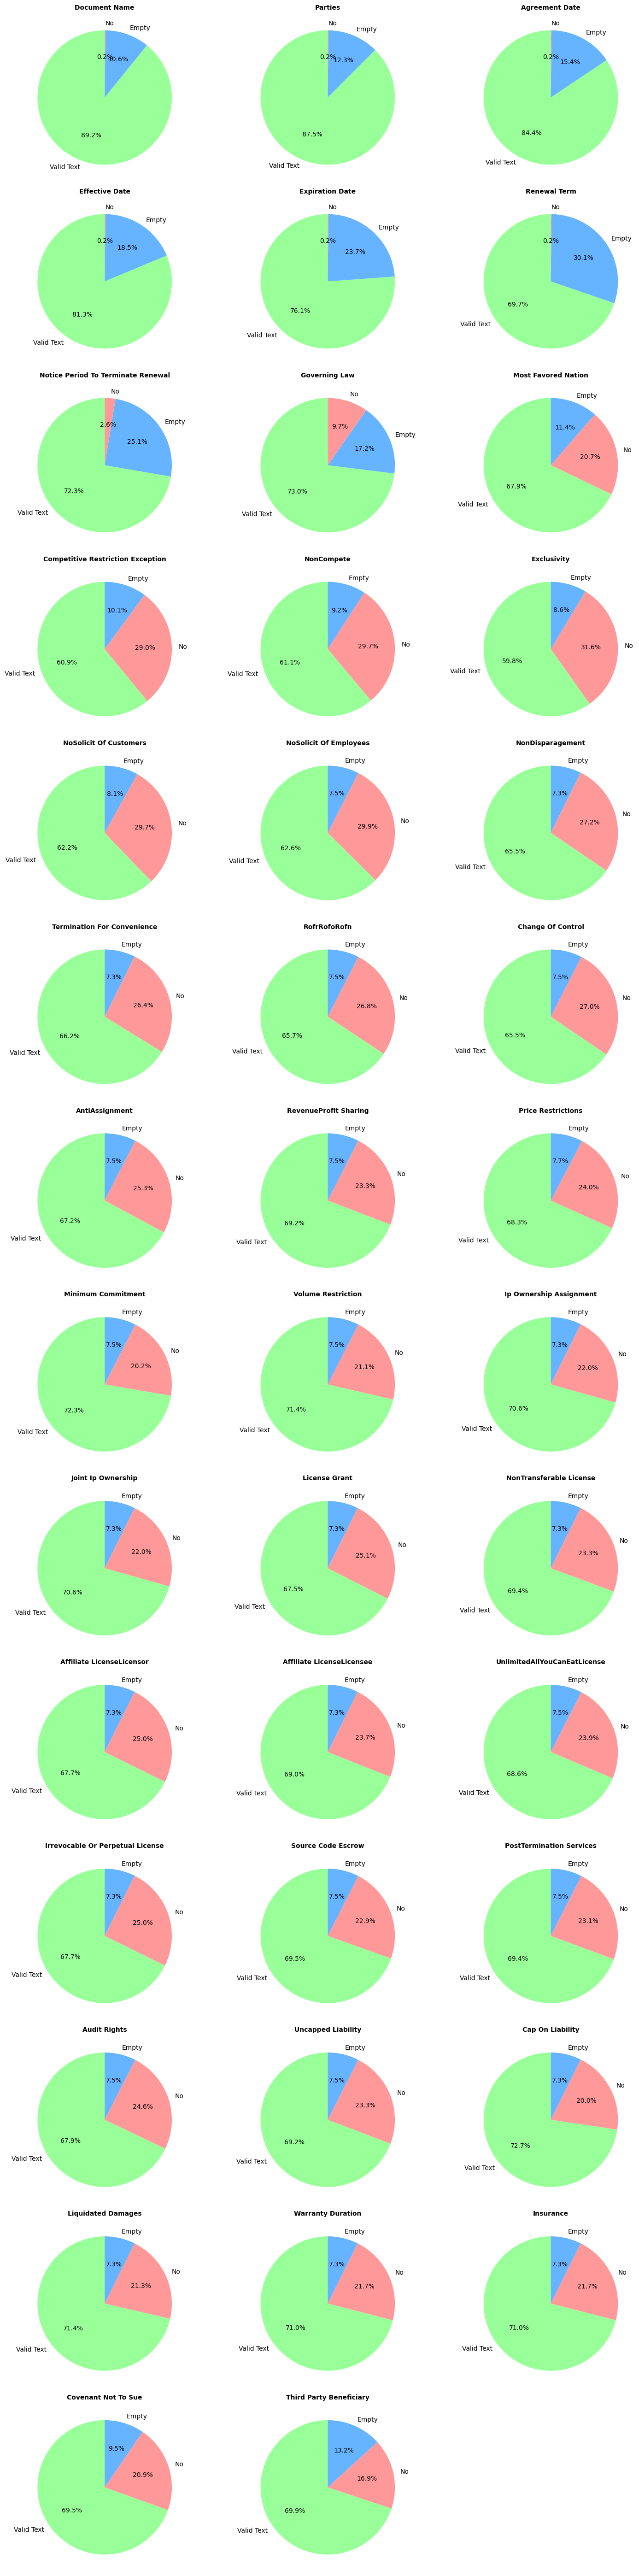

Analysis complete. Dictionary 'answer_distributions' created.


In [39]:
# ==========================================
# ANSWER DISTRIBUTION ANALYSIS
# ==========================================

answer_distributions = {}
# Identify all answer columns
answer_cols = [col for col in df.columns if col.endswith('_Answer')]

# Setup plotting grid (3 columns per row)
n_charts_per_row = 3
n_rows = (len(answer_cols) + n_charts_per_row - 1) // n_charts_per_row
fig, axes = plt.subplots(n_rows, n_charts_per_row, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(answer_cols):
    # Function to categorize content
    def get_answer_type(val):
        if pd.isna(val) or str(val).strip() == "":
            return "Empty"
        elif str(val).strip().lower() == "no":
            return "No"
        else:
            return "Valid Text"

    # Calculate distribution
    dist = df[col].apply(get_answer_type).value_counts()
    
    # Save to dictionary
    answer_distributions[col] = dist.to_dict()
    
    # Plot on the specific subplot
    ax = axes[i]
    if not dist.empty:
        # Using a standard color set for consistency: Text=Green, No=Red, Empty=Blue
        colors = {'Valid Text': '#99ff99', 'No': '#ff9999', 'Empty': '#66b3ff'}
        ax.pie(dist, labels=dist.index, autopct='%1.1f%%', startangle=90, 
               colors=[colors.get(x, '#d3d3d3') for x in dist.index])
        ax.set_title(col.replace('_Answer', ''), fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, "No Data", ha='center')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Output first few entries of the dictionary to verify
print("Analysis complete. Dictionary 'answer_distributions' created.")


--- Task 1: Risk Clause Distribution ---
             Category  Has Clause (Count)  Has Clause (%)
0  Uncapped Liability                 378           69.36
1  Liquidated Damages                 389           71.38


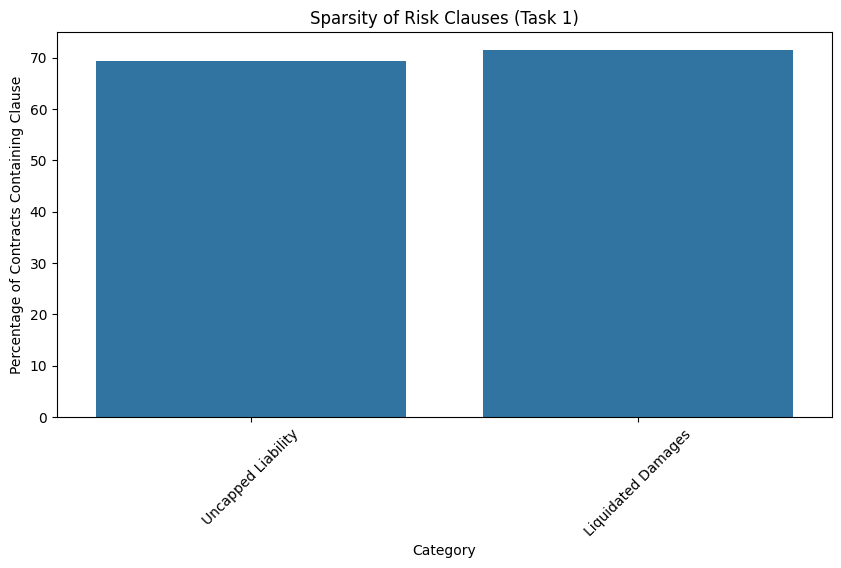

In [38]:
# ==========================================
# 3. TASK 1 ANALYSIS: RISK CLAUSE RECOGNITION
# ==========================================
# Task: Identify existence of clauses like "Termination for Convenience", "Uncapped Liability".
# Challenge: Class Imbalance. If 90% of contracts don't have these, the model might just guess "No".

risk_categories = [
    "Termination for Convenience", 
    "Uncapped Liability", 
    "Unlimited/All-You-Can-Eat License",
    "Liquidated Damages"
]

print(f"\n--- Task 1: Risk Clause Distribution ---")

stats = []
for cat in risk_categories:
    if cat in df.columns:
        # Check Answer Column (usually 'Category Answer')
        ans_col = f"{cat}_Answer" if f"{cat}_Answer" in df.columns else None
        
        if ans_col:
            # Count "Yes" vs "No" (or valid text vs empty)
            # CUAD README says: "No" if not found.
            has_clause = df[ans_col].apply(lambda x: 0 if str(x).lower() == "no" or pd.isna(x) else 1)
            count = has_clause.sum()
            stats.append({
                "Category": cat,
                "Has Clause (Count)": count,
                "Has Clause (%)": round((count / len(df)) * 100, 2)
            })

stats_df = pd.DataFrame(stats)
print(stats_df)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(data=stats_df, x="Category", y="Has Clause (%)")
plt.title("Sparsity of Risk Clauses (Task 1)")
plt.ylabel("Percentage of Contracts Containing Clause")
plt.xticks(rotation=45)
plt.show()

# Insight for Training:
# If percentages are low (<10%), you must use Prompt Engineering to force the model 
# to look harder, or use weighted loss during training.

In [13]:
# ==========================================
# 4. TASK 2 ANALYSIS: STRUCTURED ENTITY EXTRACTION
# ==========================================
# Task: Extract dates and names into valid JSON.
# Challenge: Text normalization and formatting.

entity_categories = ["Agreement Date", "Effective Date", "Parties", "Governing Law"]

print(f"\n--- Task 2: Entity Formatting Checks ---")

for cat in entity_categories:
    ans_col = f"{cat} Answer"
    if ans_col in df.columns:
        print(f"\n[Category: {cat}]")
        # Sample non-empty answers
        sample_answers = df[ans_col].dropna().sample(5).values
        print(f"Sample Answers: {sample_answers}")
        
        # Check for multiple entities (semicolons)
        multi_value_count = df[ans_col].astype(str).apply(lambda x: 1 if ";" in x else 0).sum()
        print(f"Rows with multiple values (split by ';'): {multi_value_count}")

# Insight for Training:
# Your Fine-Tuning instruction prompt must explicitly tell the model:
# "If multiple parties exist, split by semicolon" OR "Return a JSON list of strings".


--- Task 2: Entity Formatting Checks ---

[Category: Agreement Date]
Sample Answers: <ArrowStringArray>
[                                                                                                                                                                                                                                                                                                                                              ' 2013']""',
                                                                                                                                                                                                                                                                   ' and shall  continue in full force and effect until terminated as provided below.']""',
 ' provided that ETON has exercised best efforts to execute such agreement and the failure to execute is solely caused by the refusal or inability of the proposed manufacturing organization to sign a

TypeError: argument of type 'float' is not iterable

In [ ]:
# ==========================================
# 5. CONTEXT LENGTH ANALYSIS (CRITICAL FOR LLMs)
# ==========================================
# Challenge: Llama 3 has a context window (e.g., 8k). 
# We need to see if the "Context" provided in CUAD fits, or if it's too long.

# Using a rough tokenizer approximation (words * 1.3 ~ tokens) 
# or loading a real tokenizer if available.

print(f"\n--- Context Length Analysis ---")

# We analyze the length of the 'Context' text (the text from the contract)
# Note: In CUAD CSV, the column with the Category Name usually contains the extraction text context.

lengths = []
for cat in categories:
    # Filter out "No" answers (where context might be empty)
    # We only care about the length of text when the clause ACTUALLY exists.
    valid_rows = df[df[f"{cat} Answer"].astype(str).str.lower() != "no"]
    
    # Get length of the text context
    # Fill NA to avoid errors
    text_lengths = valid_rows[cat].fillna("").astype(str).apply(lambda x: len(x.split()) * 1.3)
    lengths.extend(text_lengths.tolist())

# Plotting Token Distribution
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=50, kde=True)
plt.title("Estimated Token Length of Extracted Clauses")
plt.xlabel("Estimated Tokens")
plt.axvline(x=256, color='r', linestyle='--', label='256 Tokens')
plt.axvline(x=512, color='g', linestyle='--', label='512 Tokens')
plt.legend()
plt.show()

print(f"Average Clause Token Count: {sum(lengths)/len(lengths):.2f}")
print(f"Max Clause Token Count: {max(lengths):.2f}")

# Insight for Training:
# If max length is < 512 tokens, you don't need distinct 'Long Context' strategies.
# You can fit (System Prompt + Instruction + Clause Context + Answer) easily into 2048 or 4096 context.

In [ ]:
# ==========================================
# 6. TRAINING / VALIDATION SPLIT STRATEGY
# ==========================================
# As per your requirements, we split by CONTRACT (Row), not by clause.
# This prevents data leakage (where the model memorizes a specific contract's style).

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

print(f"\n--- Data Splitting ---")
print(f"Training Set: {len(train_df)} contracts")
print(f"Validation Set: {len(val_df)} contracts")

# Save these split files if needed for the actual training pipeline
# train_df.to_csv("cuad_train_split.csv", index=False)
# val_df.to_csv("cuad_val_split.csv", index=False)

In [ ]:
# ==========================================
# 7. PREVIEW: INSTRUCTION TUNING FORMAT
# ==========================================
# Transforming a row into Llama 3 JSON format (Task 2 Example)

print(f"\n--- Fine-Tuning Data Preview (Task 2) ---")

def create_prompt_example(row, category):
    ans_col = f"{category} Answer"
    context = row[category]
    answer = row[ans_col]
    
    # Skip empty/No answers for this preview
    if str(answer).lower() == "no" or pd.isna(context):
        return None

    # Construct the JSON structure
    training_entry = {
        "instruction": f"Extract the {category} from the following legal text. Output as JSON.",
        "input": str(context).strip(),
        "output": json.dumps({category: answer})
    }
    return training_entry

# Example for 'Agreement Date'
sample_row = df[df['Agreement Date Answer'].astype(str) != "No"].iloc[0]
example = create_prompt_example(sample_row, "Agreement Date")

print(json.dumps(example, indent=2))